# Extending the gstlearn

The aim of this tutorial is to show how to customize the default behaviour of the **gstlearn** package. The choosen example here shows how to define your own moving neighborhood criteria.

In [37]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Initialization

In [101]:
import pandas as pd
import numpy as np
import gstlearn as gl
import gstlearn.plot as gp
import urllib.request

In [102]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.csv'
filecsv, head = urllib.request.urlretrieve(url)
datcsv = pd.read_csv(filecsv, na_values="MISS")
datcsv

,Longitude,Latitude,Elevation,January_temp
0,372.1,658.9,255,1.7
1,303.5,665.9,125,2.0
2,218.4,597.9,8,4.6
3,245.0,955.0,90,NaN
4,326.8,691.2,32,3.1
...,...,...,...,...
231,273.2,564.6,47,2.8
232,333.9,730.1,30,2.6
233,185.0,655.0,115,NaN
234,259.8,587.9,119,2.1


We create a Db and set the **locators** for the coordinates and the variable of interest. We then create a selection to mask automatically undefined values for the temperature variable.

In [137]:
data = gl.Db()
for field in datcsv.columns :
  data[field] = datcsv[field]
data.setLocators(["Longitude","Latitude"], gl.ELoc.X)
data.setLocator("January_temp", gl.ELoc.Z)
# Selection for defined values only
data["TempOK"] = ~np.isnan(data["January_temp"])
data.setLocator("TempOK", gl.ELoc.SEL)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236
Number of active samples     = 151

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = NA
Column = 3 - Name = January_temp - Locator = z1
Column = 4 - Name = TempOK - Locator = sel

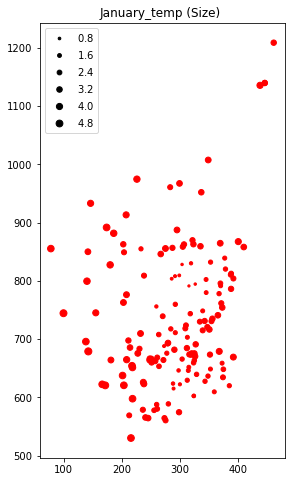

In [126]:
gp.plot(data,sizmin=5,sizmax=50,flagLegendSymbol=True)

We create automatically a grid data base covering all the data points. Number of node is choosen by trial/error in order to have more or less an homogeneous mesh size.

In [142]:
grid = gl.DbGrid.createCoveringDb(data, nx=[80,130], margin=[50,50])
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 2
Maximum Number of UIDs       = 2
Total number of samples      = 10400

Grid characteristics:
---------------------
Origin :     28.200   480.400
Mesh   :      6.108     6.035
Number :         80       130

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2

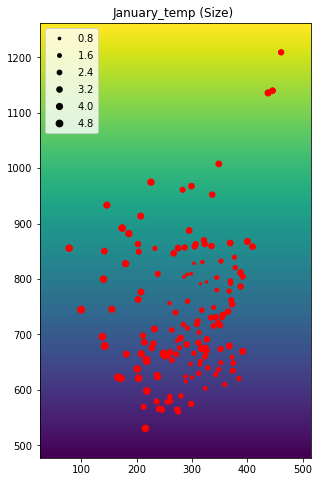

In [127]:
gp.plot(grid)
gp.plot(data,sizmin=5,sizmax=50,flagLegendSymbol=True)

# Playing with NeighMoving

We create a moving neighborhood definition object having only one big sector (a circle) with maximum 3 samples.

In [143]:
nmini = 1
nmaxi = 3
radius = 300 # Big radius
nsect = 1
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect)
neigh


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 3
Maximum horizontal distance         = 300

We trigger the moving neighborhood algorithm applied to the target node (of the grid) which rank is 4511. We obtain three neighbors and display their ranks. 

In [135]:
node = 4511
neigh.attach(data, grid)
ranks = neigh.select(node)
ranks # Ranks 23, 75 and 143

array([ 23,  75, 143])

Here is a small function using ax.neigh gstlearn function that offer the capability to display neigh results. The target node is in black and the neighbors in blue.

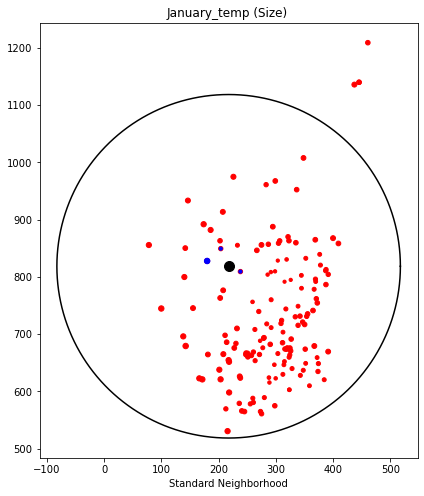

In [146]:
def show_neigh(data, grid, neigh, node, ranks):
  ax = data.plot(name_size="January_temp",sizmax=30, useSel=True)
  if (len(ranks) > 0):
    dataSel = data.clone()
    dataSel.addSelectionByRanks(ranks)
    ax = dataSel.plot(color='blue',name_size="January_temp",sizmax=30)
  ax.neigh(neigh, grid, node)
  ax.decoration("Standard Neighborhood")
    
show_neigh(data, grid, neigh, node, ranks)

We reduce the radius of the circle so that only one neighbor will be selected.

In [147]:
nmini = 1
nmaxi = 3
radius = 30 # Smaller radius
nsect = 1
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect)
neigh


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 3
Maximum horizontal distance         = 30

In [148]:
node = 4511
neigh.attach(data, grid)
ranks = neigh.select(node)
ranks # Only rank 143

array([143])

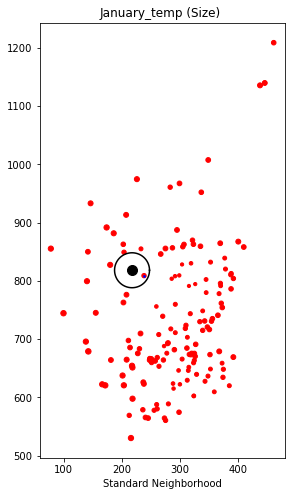

In [149]:
show_neigh(data, grid, neigh, node, ranks)

# Extending the gstlearn

In this pargraph, we want to add our own neighborhood "checker" by defining it in Python. We choose to mimick the maximum radius checker which is already available in the standard *NeighMoving* class.

We create a new class (in Python) that inherits from the **gstlearn** C++ class named *ABiTargetCheck*. In that class, we define a member called *radius* and override two abstract methods:
 - isOK: that returns *True* if two space targets (see SpaceTarget class) are considered in the same neighborhood.
 - toString: that returns the characters string describing the class content.

In [150]:
class BiTargetCheckMaxRadius(gl.ABiTargetCheck):
    def __init__(self, radius):
        super(BiTargetCheckMaxRadius,self).__init__()
        self.radius = radius
        
    def isOK(self,st1,st2):
        return st1.getDistance(st2) < self.radius
    
    def toString(self,strfmt):
        return "This is my Max Radius checker: {}".format(self.radius)


Then, we recreate a NeighMoving object having a big radius (should select 3 neighbors), but we add our customized checker which indicates a small radius. Doing that, we hope that the neighborhood algorithm will select back only one sample (with rank 143).

In [152]:
nmini = 1
nmaxi = 3
radius = 300 # Big radius
neigh2 = gl.NeighMoving.create(False, nmaxi=nmaxi, nmini=nmini,radius=radius)
# Prefer my own maximum radius checker!
btc = BiTargetCheckMaxRadius(30)
neigh2.addBiTargetCheck(btc)
neigh2.display()


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 3
Maximum horizontal distance         = 300
This is my Max Radius checker: 30 

In [154]:
node = 4511
neigh2.attach(data, grid)
ranks = neigh2.select(node)
ranks # Should return 143

array([143])

Here, the big ellipsoid circle is shown (default behavior) but only one sample is selected due to our customized checker.

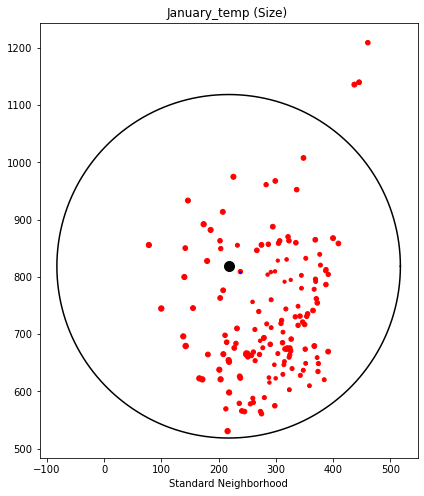

In [155]:
show_neigh(data, grid, neigh2, node, ranks)